<a href="https://colab.research.google.com/github/Elcejas77/Aprendizaje-de-Maquina/blob/main/Ejercicio_Ropa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
!pip install umap-learn


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import cv2
from skimage.util import random_noise
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import umap



In [7]:

def add_gaussian_noise(image, snr_db=3):
    """Agrega ruido gaussiano a la imagen con una SNR específica en dB."""
    signal_power = np.mean(image ** 2)
    noise_power = signal_power / (10 ** (snr_db / 10))
    noise = np.random.normal(0, np.sqrt(noise_power), image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)

def add_salt_pepper_noise(image, amount=0.02):
    """Agrega ruido de sal y pimienta a la imagen."""
    return random_noise(image, mode='s&p', amount=amount)


In [8]:

# Cargar Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalizar imágenes (0 a 1)
x_train = x_train.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

# Agregar ruido
x_train_gaussian = np.array([add_gaussian_noise(img) for img in x_train])
x_test_gaussian = np.array([add_gaussian_noise(img) for img in x_test])

x_train_sp = np.array([add_salt_pepper_noise(img) for img in x_train])
x_test_sp = np.array([add_salt_pepper_noise(img) for img in x_test])

# Expandir dimensiones para usar con CNN
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)
x_train_gaussian = np.expand_dims(x_train_gaussian, axis=-1)
x_test_gaussian = np.expand_dims(x_test_gaussian, axis=-1)
x_train_sp = np.expand_dims(x_train_sp, axis=-1)
x_test_sp = np.expand_dims(x_test_sp, axis=-1)


In [9]:

# Definir arquitectura del modelo
input_clean = Input(shape=(28, 28, 1), name='clean_input')
input_gaussian = Input(shape=(28, 28, 1), name='gaussian_input')
input_sp = Input(shape=(28, 28, 1), name='sp_input')

# Concatenar entradas
merged_inputs = concatenate([input_clean, input_gaussian, input_sp])

# Capas convolucionales
x = Conv2D(32, (3, 3), activation='relu', padding='same')(merged_inputs)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)

# Salidas
class_output = Dense(10, activation='softmax', name='class_output')(x)
gender_output = Dense(3, activation='softmax', name='gender_output')(x)

# Definir modelo
model = Model(inputs=[input_clean, input_gaussian, input_sp], outputs=[class_output, gender_output])

# Compilar modelo
model.compile(optimizer='adam', loss={'class_output': 'sparse_categorical_crossentropy', 'gender_output': 'sparse_categorical_crossentropy'}, metrics={'class_output': 'accuracy', 'gender_output': 'accuracy'})



In [10]:
# Callbacks para mejorar entrenamiento
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

# Entrenar el modelo
history = model.fit(
    [x_train, x_train_gaussian, x_train_sp],
    {'class_output': y_train, 'gender_output': y_train % 3},
    validation_data=([x_test, x_test_gaussian, x_test_sp], {'class_output': y_test, 'gender_output': y_test % 3}),
    epochs=50,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)



Epoch 1/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - class_output_accuracy: 0.6987 - class_output_loss: 0.8539 - gender_output_accuracy: 0.7782 - gender_output_loss: 0.5146 - loss: 1.3685 - val_class_output_accuracy: 0.8694 - val_class_output_loss: 0.3508 - val_gender_output_accuracy: 0.9136 - val_gender_output_loss: 0.2348 - val_loss: 0.5863 - learning_rate: 0.0010
Epoch 2/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 23s 6ms/step - class_output_accuracy: 0.8619 - class_output_loss: 0.3903 - gender_output_accuracy: 0.9053 - gender_output_loss: 0.2559 - loss: 0.6462 - val_class_output_accuracy: 0.8826 - val_class_output_loss: 0.3232 - val_gender_output_accuracy: 0.9205 - val_gender_output_loss: 0.2038 - val_loss: 0.5281 - learning_rate: 0.0010
Epoch 3/50
938/938 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - class_output_accuracy: 0.8837 - class_output_loss: 0.3228 - gender_output_accuracy: 0.9223 - gender_output_loss: 0.2067 - loss: 0.5296 - val_class_output_accuracy: 0.8950 - val_class_output_loss: 0.2828 

In [11]:
# Evaluación del modelo
y_pred_class, y_pred_gender = model.predict([x_test, x_test_gaussian, x_test_sp])
y_pred_class = np.argmax(y_pred_class, axis=1)
y_pred_gender = np.argmax(y_pred_gender, axis=1)



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [12]:
# Reportes de clasificación
print("Classification Report - Prenda:")
print(classification_report(y_test, y_pred_class))
print("Classification Report - Género:")
print(classification_report(y_test % 3, y_pred_gender))



Classification Report - Prenda:
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1000
           1       0.99      0.98      0.99      1000
           2       0.86      0.88      0.87      1000
           3       0.92      0.92      0.92      1000
           4       0.87      0.86      0.87      1000
           5       0.99      0.99      0.99      1000
           6       0.76      0.75      0.75      1000
           7       0.95      0.99      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000

Classification Report - Género:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      4000
           1       0.94      0.94      0.94      3000
           2  

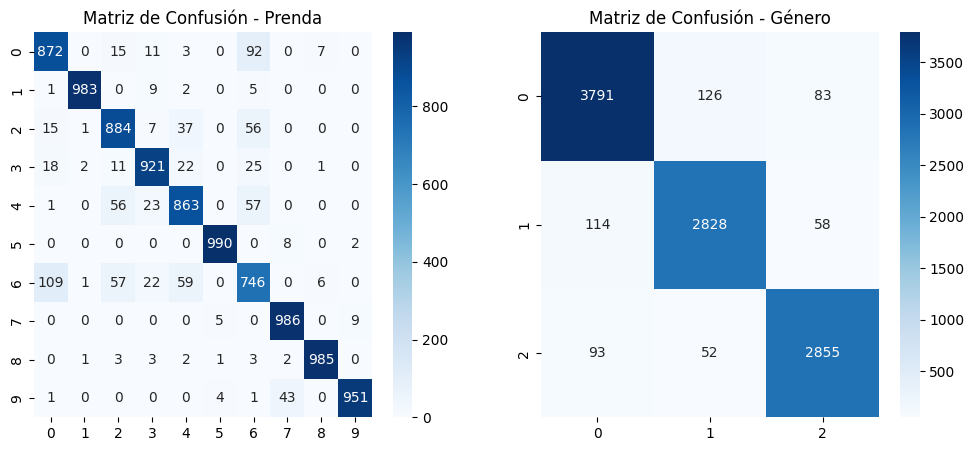

In [13]:
# Matrices de confusión
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(confusion_matrix(y_test, y_pred_class), annot=True, fmt='d', cmap='Blues', ax=ax[0])
ax[0].set_title("Matriz de Confusión - Prenda")
sns.heatmap(confusion_matrix(y_test % 3, y_pred_gender), annot=True, fmt='d', cmap='Blues', ax=ax[1])
ax[1].set_title("Matriz de Confusión - Género")
plt.show()



313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


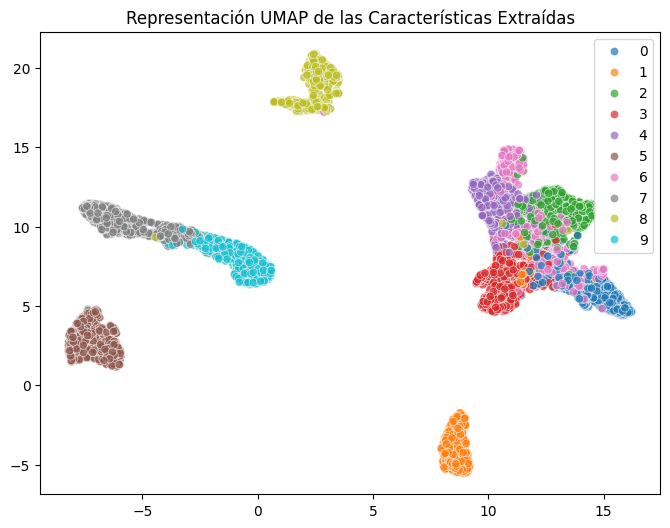

In [14]:
# Reducción de dimensionalidad con UMAP
feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)
features = feature_extractor.predict([x_test, x_test_gaussian, x_test_sp])
reduced_features = umap.UMAP(n_components=2).fit_transform(features)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_features[:, 0], y=reduced_features[:, 1], hue=y_test, palette='tab10', alpha=0.7)
plt.title("Representación UMAP de las Características Extraídas")
plt.show()